In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Datasets

marketing_df = pd.read_csv(r"F:\INTERNSHIP\Combined project\marketing_campaign.csv", sep=';')
ecommerce_df = pd.read_csv(r"F:\INTERNSHIP\Combined project\E commerce data.csv", encoding='ISO-8859-1')


In [3]:

ecommerce_df = ecommerce_df.dropna(subset=['CustomerID', 'Description', 'Quantity', 'UnitPrice', 'InvoiceDate'])
ecommerce_df['CustomerID'] = ecommerce_df['CustomerID'].astype(int)
ecommerce_df = ecommerce_df[(ecommerce_df['Quantity'] > 0) & (ecommerce_df['UnitPrice'] > 0)]
ecommerce_df['TotalPrice'] = ecommerce_df['Quantity'] * ecommerce_df['UnitPrice']
ecommerce_df['InvoiceDate'] = pd.to_datetime(ecommerce_df['InvoiceDate'], errors='coerce')


# Derived Features (RFM Analysis)


In [4]:

reference_date = ecommerce_df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm_df = ecommerce_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']



# Customer Segmentation


## K-Means Clustering for Segmentation


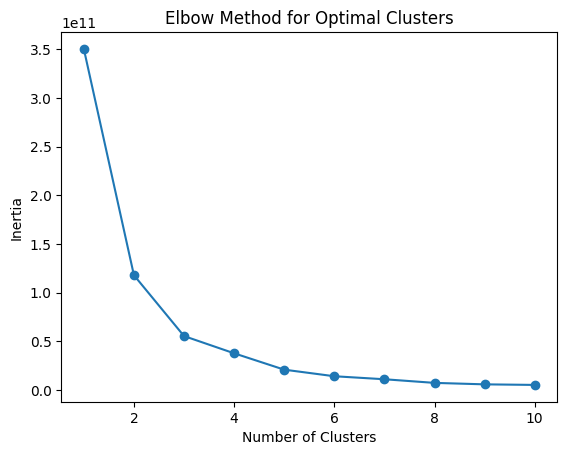

           Recency  Frequency       Monetary
Cluster                                     
0        95.045086   3.483063    1167.530218
1         2.600000  76.400000  209342.334000
2        46.789474  40.789474   65622.708421
3        17.147541  22.737705   14127.689344


In [5]:

rfm_data = rfm_df[['Recency', 'Frequency', 'Monetary']]
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_data)

print(rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}))


# Normalization for feature scaling


In [6]:
scaler = MinMaxScaler()
rfm_df[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])


In [7]:

print(rfm_df.head())


   CustomerID   Recency  Frequency  Monetary  Cluster
0       12346  0.871314   0.000000  0.275443        2
1       12347  0.002681   0.028846  0.015368        0
2       12348  0.198391   0.014423  0.006401        0
3       12349  0.048257   0.000000  0.006259        0
4       12350  0.828418   0.000000  0.001180        0


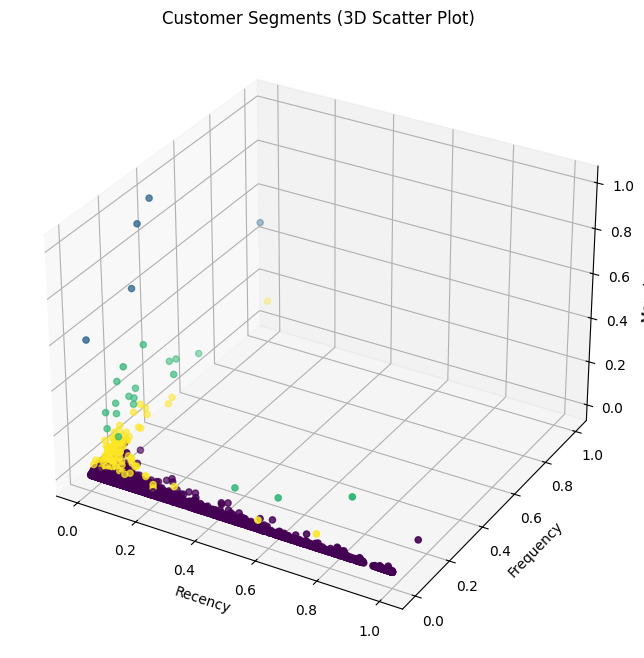

In [8]:
# Visualize Segments

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rfm_df['Recency'], rfm_df['Frequency'], rfm_df['Monetary'], c=rfm_df['Cluster'], cmap='viridis')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.title('Customer Segments (3D Scatter Plot)')
plt.show()


In [9]:

rfm_df.to_csv(r"F:\INTERNSHIP\Combined project\customer_segments.csv", index=False)

print("Customer Segments saved to customer_segments.csv.")


Customer Segments saved to customer_segments.csv.


In [10]:
Distribution of RFM Features

SyntaxError: invalid syntax (3967216104.py, line 1)

In [ ]:
import seaborn as sns

# Plot the distribution of RFM metrics
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(rfm_df['Recency'], kde=True, ax=ax[0])
ax[0].set_title('Distribution of Recency')

sns.histplot(rfm_df['Frequency'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Frequency')

sns.histplot(rfm_df['Monetary'], kde=True, ax=ax[2])
ax[2].set_title('Distribution of Monetary')

plt.tight_layout()
plt.show()


In [ ]:
# Summary of customer segments
segment_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std']
})
print(segment_summary)


In [11]:
# Create a new target column 'RepeatPurchase'
rfm_df['RepeatPurchase'] = rfm_df['Frequency'].apply(lambda x: 1 if x > 1 else 0)

X = rfm_df[['Recency', 'Frequency', 'Monetary']]
y = rfm_df['RepeatPurchase']


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


rfm_df['RepeatBuyer'] = (rfm_df['Frequency'] > 1).astype(int)

print(rfm_df['RepeatBuyer'].value_counts())  # Make sure this shows both 0 and 1

X = rfm_df[['Recency', 'Monetary']]
y = rfm_df['RepeatBuyer']

if len(y.unique()) > 1:
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
else:
    print("Error: Only one class present in target variable. Logistic Regression needs at least two classes.")


RepeatBuyer
0    4338
Name: count, dtype: int64
Error: Only one class present in target variable. Logistic Regression needs at least two classes.


In [13]:
print(y.value_counts())


RepeatBuyer
0    4338
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:58 - cmdstanpy - INFO - Chain [1] done processing


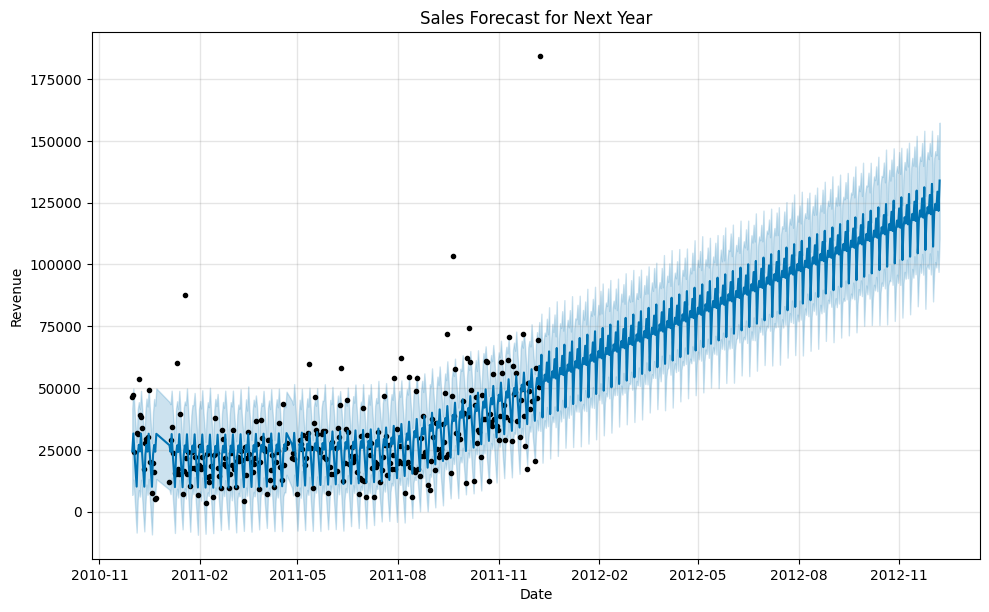

In [14]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare the data: it must have columns 'ds' (date) and 'y' (value)
sales_data = ecommerce_df.groupby(ecommerce_df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
sales_data.columns = ['ds', 'y']

# Initialize and fit the model
model = Prophet()
model.fit(sales_data)

# Predict for the next 365 days
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title("Sales Forecast for Next Year")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


In [15]:
# Export RFM data with clusters
rfm_df.to_csv(r"F:\INTERNSHIP\Combined project\rfm_data.csv", index=False)

# Export the eCommerce data (if you want to analyze products, etc.)
ecommerce_df.to_csv(r"F:\INTERNSHIP\Combined project\ecommerce_data.csv", index=False)

# Export Prophet forecast data (for future sales prediction)
forecast[['ds', 'yhat']].to_csv(r"F:\INTERNSHIP\Combined project\sales_forecast.csv", index=False)

print("Data exported successfully!")


Data exported successfully!
